In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 100
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("../data/clean_woodland_data.csv")
df

,Date,P (kW)
0,2022-01-01 06:00:00,0.000000
1,2022-01-01 07:00:00,0.410583
2,2022-01-01 08:00:00,2.762083
3,2022-01-01 09:00:00,5.461250
4,2022-01-01 10:00:00,8.356167
...,...,...
25645,2024-12-04 19:00:00,0.000000
25646,2024-12-04 20:00:00,0.000000
25647,2024-12-04 21:00:00,0.000000
25648,2024-12-04 22:00:00,0.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25650 entries, 0 to 25649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    25650 non-null  object 
 1   P (kW)  25650 non-null  float64
dtypes: float64(1), object(1)
memory usage: 400.9+ KB


In [7]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [8]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [9]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7620833e+00,
        4.1058330e-01, 0.0000000e+00],
       [7.4316670e-01, 0.0000000e+00, 0.0000000e+00, ..., 5.4612500e+00,
        2.7620833e+00, 4.1058330e-01],
       [4.3818335e+00, 7.4316670e-01, 0.0000000e+00, ..., 8.3561670e+00,
        5.4612500e+00, 2.7620833e+00],
       ...,
       [1.1980000e-02, 0.0000000e+00, 1.5033335e-01, ..., 2.9400000e-03,
        1.9600000e-03, 9.8000000e-04],
       [2.3960000e-02, 1.1980000e-02, 0.0000000e+00, ..., 3.9200000e-03,
        2.9400000e-03, 1.9600000e-03],
       [3.5940000e-02, 2.3960000e-02, 1.1980000e-02, ..., 4.9000000e-03,
        3.9200000e-03, 2.9400000e-03]])

In [10]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [11]:
X.shape, y.shape

((25602, 24), (25602,))

In [12]:
split_index = int(len(X) * 0.8)

In [13]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20481, 24), (5121, 24), (20481,), (5121,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20481, 24, 1), (5121, 24, 1), (20481, 1), (5121, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([20481, 24, 1]),
 torch.Size([5121, 24, 1]),
 torch.Size([20481, 1]),
 torch.Size([5121, 1]))

In [16]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [18]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


In [20]:
class CustomNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.W = nn.Parameter(torch.Tensor(input_size, hidden_size), requires_grad = True)
        self.lstm = nn.RNN(hidden_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.tanh(x @ self.W)
        x_, h = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [21]:
customnet = CustomNet(input_size, hidden_size, num_classes).to(device)
customnet_optimizer = torch.optim.Adam(customnet.parameters(), lr = learning_rate)

In [22]:
total_customnet_parameters = count_parameters(customnet)

In [23]:
customnet_train_loss_array = []
customnet_val_loss_array = []

In [24]:
customnet_start_time = time.time()
train_and_validate(epochs, device, customnet, train_loader, val_loader, criterion, customnet_optimizer, customnet_train_loss_array, customnet_val_loss_array)
customnet_end_time = time.time()
customnet_total_training_time = customnet_end_time - customnet_start_time
customnet_avg_training_time_per_epoch = customnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 6.271130392609573 | Validation Loss: 2.4131390894181095
Epoch no.: 2 | Training Loss: 3.5150569741318867 | Validation Loss: 2.393743608863308
Epoch no.: 3 | Training Loss: 3.4296749347593725 | Validation Loss: 2.4206280304620473
Epoch no.: 4 | Training Loss: 3.367402047064246 | Validation Loss: 2.3787349135270164
Epoch no.: 5 | Training Loss: 3.35262408605436 | Validation Loss: 2.4072587448351372
Epoch no.: 6 | Training Loss: 3.345636392221218 | Validation Loss: 2.388520080150696
Epoch no.: 7 | Training Loss: 3.3066384452145274 | Validation Loss: 2.3598349006542074
Epoch no.: 8 | Training Loss: 3.304824131872596 | Validation Loss: 2.3703438328364146
Epoch no.: 9 | Training Loss: 3.2945425748825072 | Validation Loss: 2.36280859924423
Epoch no.: 10 | Training Loss: 3.2653458592368336 | Validation Loss: 2.442567108204597
Epoch no.: 11 | Training Loss: 3.315377643050217 | Validation Loss: 2.3685744606996457
Epoch no.: 12 | Training Loss: 3.2683162706654247 | V

In [25]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     CustomNet: {total_customnet_parameters}")
print()
print(f"Total Training Time:     CustomNet: {customnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     CustomNet: {customnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     CustomNet: 20401

Total Training Time:     CustomNet: 104.82s

Average Training Time Per Epoch:     CustomNet: 1.05s
------------------------------------------------------------


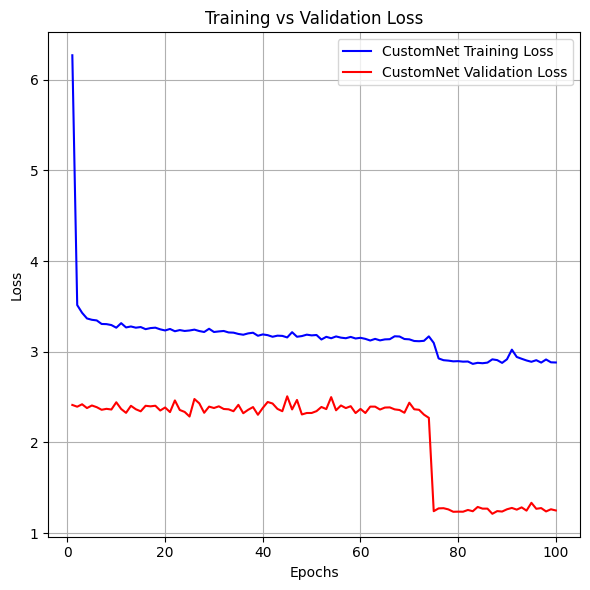

In [26]:
plot_loss_comparison(epochs, customnet_train_loss_array, customnet_val_loss_array, "CustomNet Training Loss", "CustomNet Validation Loss", "Training vs Validation Loss")

In [27]:
customnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = customnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_13420\1908420732.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


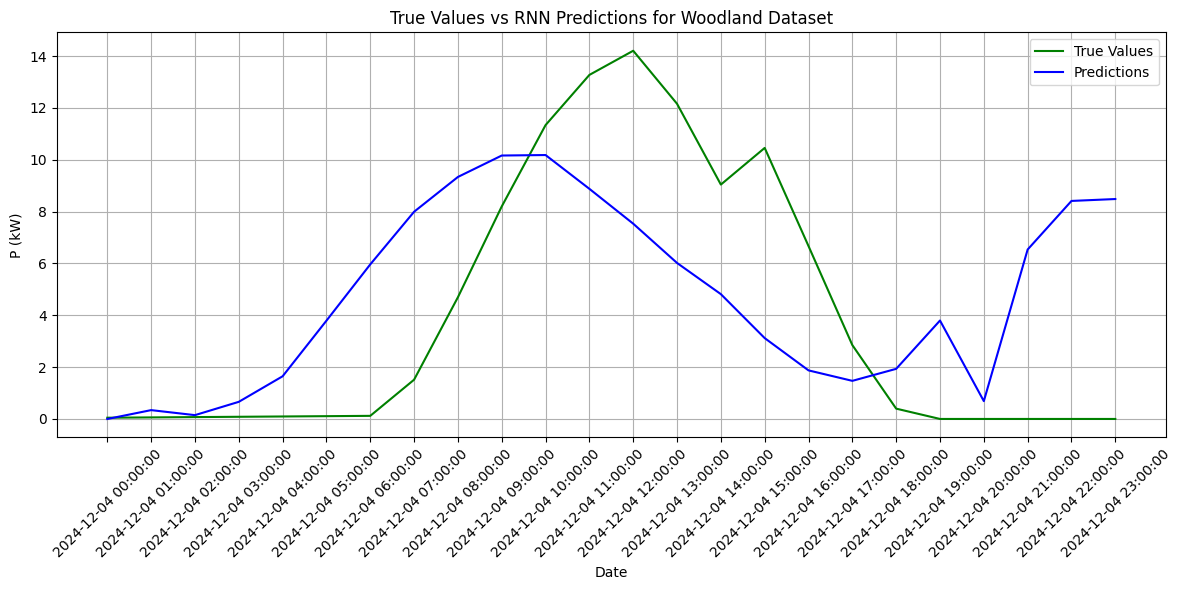

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs RNN Predictions for Woodland Dataset')
plt.xlabel('Date')
plt.ylabel('P (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
mse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Mean Squared Error: {mse}")
print(f'R-squared value: {r2}')

Mean Squared Error: 4.65517725524066
R-squared value: 0.14835287148164422
